# Hierarchical Synthetic Spectra Fitting

Fitting real data properties using the `RealDataFitter` and `ComponentFitter` tools.

This notebook demonstrates:
1. Loading a real dataset
2. Using `RealDataFitter` to automatically infer all generator parameters
3. Using `ComponentFitter` to unmix spectral components
4. Generating synthetic spectra that match the real data
5. Validating the synthetic data quality

In [1]:
# === IMPORTS ===
import sys
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Add nirs4all to path
root = Path.cwd().parent.parent
if str(root) not in sys.path:
    sys.path.insert(0, str(root))

import nirs4all
from nirs4all.data import DatasetConfigs
from nirs4all.data.synthetic import (
    # Core generator
    SyntheticNIRSGenerator,
    ComponentLibrary,
    get_predefined_components,
    # Fitting tools (new API)
    RealDataFitter,
    FittedParameters,
    ComponentFitter,
    fit_components,
    compute_spectral_properties,
    compare_datasets,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 4)
plt.rcParams['figure.dpi'] = 100

---
## 1. Load Real Dataset

In [2]:
# === CONFIGURE DATASET ===
DATASET_PATH = Path("/home/delete/NIRS DB/x_bank")
# DATASET_NAME = "Beef_Marbling_RandomSplit"
DATASET_NAME = "DIESEL_d_263_hla-b"
csv_path = DATASET_PATH / (DATASET_NAME + ".csv")

config = {
    "x_train": str(csv_path),
    "delimiter": ",",
    "has_header": True,
    "header_unit": "nm",
}
configs = DatasetConfigs(config)
dataset = configs.get_datasets()[0]

X_real = dataset.x({}, layout='2d')
wavelengths = dataset.wavelengths_nm(0)
if wavelengths is None:
    wavelengths = np.arange(X_real.shape[1])

print(f"Dataset: {dataset.name}")
print(f"Shape: {X_real.shape}")
print(f"Wavelengths: {wavelengths.min():.1f} - {wavelengths.max():.1f} nm")
print(f"Absorbance range: [{X_real.min():.4f}, {X_real.max():.4f}]")

Dataset: x_bank_DIESEL_d_263_hla-b
Shape: (263, 401)
Wavelengths: 750.0 - 1550.0 nm
Absorbance range: [-0.0409, 0.0628]


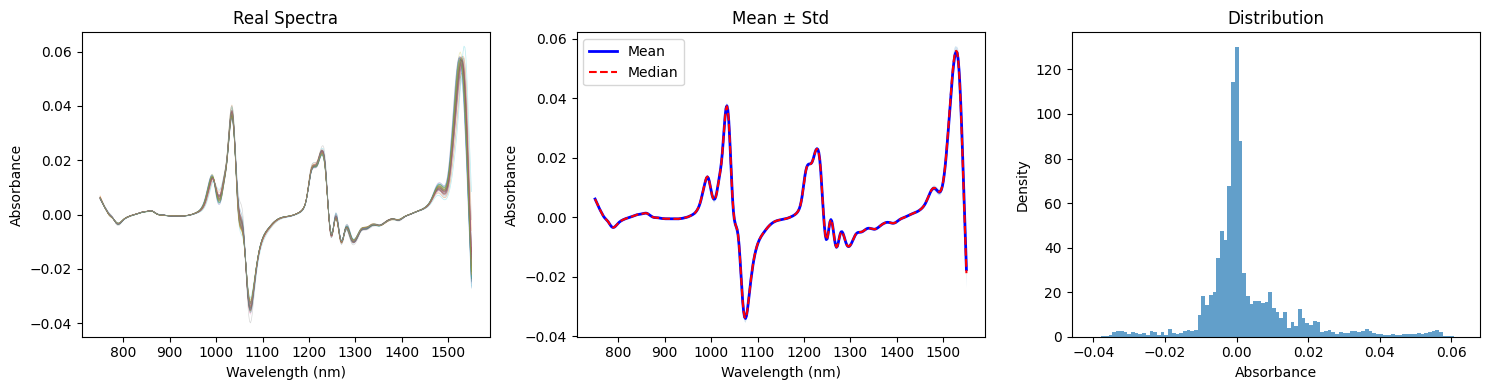

In [3]:
# Display real dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Spectra
for i in np.random.choice(len(X_real), min(50, len(X_real)), replace=False):
    axes[0].plot(wavelengths, X_real[i], alpha=0.3, lw=0.5)
axes[0].set(xlabel='Wavelength (nm)', ylabel='Absorbance', title='Real Spectra')

# Mean/Median
axes[1].plot(wavelengths, X_real.mean(axis=0), 'b-', lw=2, label='Mean')
axes[1].plot(wavelengths, np.median(X_real, axis=0), 'r--', lw=1.5, label='Median')
axes[1].fill_between(wavelengths, X_real.mean(0) - X_real.std(0), X_real.mean(0) + X_real.std(0), alpha=0.2)
axes[1].set(xlabel='Wavelength (nm)', ylabel='Absorbance', title='Mean ± Std')
axes[1].legend()

# Distribution
axes[2].hist(X_real.flatten(), bins=100, density=True, alpha=0.7)
axes[2].set(xlabel='Absorbance', ylabel='Density', title='Distribution')

plt.tight_layout()
plt.show()

---
## 2. Compute Spectral Properties

Using `compute_spectral_properties()` to analyze the real dataset characteristics.

In [4]:
# Compute spectral properties using the new API
real_props = compute_spectral_properties(X_real, wavelengths, name=dataset.name)

print(f"{'Property':<30} {'Value':>15}")
print("=" * 48)
print(f"{'Samples':<30} {real_props.n_samples:>15}")
print(f"{'Wavelengths':<30} {real_props.n_wavelengths:>15}")
print(f"{'Global mean':<30} {real_props.global_mean:>15.4f}")
print(f"{'Global std':<30} {real_props.global_std:>15.4f}")
print(f"{'Mean slope (/1000nm)':<30} {real_props.mean_slope:>15.4f}")
print(f"{'Slope std':<30} {real_props.slope_std:>15.4f}")
print(f"{'Noise estimate':<30} {real_props.noise_estimate:>15.5f}")
print(f"{'SNR estimate':<30} {real_props.snr_estimate:>15.1f}")
print(f"{'PCs for 95% variance':<30} {real_props.pca_n_components_95:>15}")
print(f"{'Effective resolution (nm)':<30} {real_props.effective_resolution:>15.1f}")
print()
print("Domain indicators:")
print(f"  Water band intensity:        {real_props.water_band_intensity:.4f}")
print(f"  Protein band intensity:      {real_props.protein_band_intensity:.4f}")
print(f"  Lipid band intensity:        {real_props.lipid_band_intensity:.4f}")
print(f"  Carbohydrate band intensity: {real_props.carbohydrate_band_intensity:.4f}")

Property                                 Value
Samples                                    263
Wavelengths                                401
Global mean                             0.0026
Global std                              0.0131
Mean slope (/1000nm)                    0.0136
Slope std                               0.0005
Noise estimate                         0.00137
SNR estimate                               0.4
PCs for 95% variance                         3
Effective resolution (nm)                 33.6

Domain indicators:
  Water band intensity:        0.0040
  Protein band intensity:      0.0249
  Lipid band intensity:        0.0000
  Carbohydrate band intensity: 0.0000


---
## 3. Fit Generator Parameters with RealDataFitter

The `RealDataFitter` class automatically infers:
- Wavelength grid parameters
- Noise and scatter parameters  
- Instrument archetype
- Measurement mode
- Application domain
- Environmental effects
- Scattering characteristics

In [5]:
# Fit parameters from real data using RealDataFitter
fitter = RealDataFitter()
fitted_params = fitter.fit(
    X_real,
    wavelengths=wavelengths,
    name=dataset.name,
    infer_instrument=True,
    infer_domain=True,
    infer_measurement_mode=True,
    infer_environmental=True,
    infer_scattering=True,
)

# Display summary
print(fitted_params.summary())

Fitted Parameters Summary: x_bank_DIESEL_d_263_hla-b

Wavelength Grid:
  Range: 750 - 1550 nm
  Step: 2.0 nm

Noise & Scatter:
  Base noise: 0.00068
  Signal-dependent noise: 0.05227
  Multiplicative scatter (α): 0.0392
  Additive scatter (β): 0.0013

Baseline & Slope:
  Global slope: 0.0136 ± 0.0005
  Baseline amplitude: 0.0026
  Path length std: 0.0003

Complexity: complex

Phase 1-4 Inferences:
  Instrument: scio
  Measurement mode: reflectance (confidence: 0.64)
  Domain: unknown
  Detected components: None
  Suggested n_components: 5

Preprocessing Detection:
  Type: second_derivative
  Is preprocessed: True
  Confidence: 0.26
  Zero-crossing ratio: 0.022
  Oscillation frequency: 0.146
  Suggested inverse: cumulative_sum_twice (or use SG derivatives in forward pipeline)


In [6]:
# Display detailed inference results
print("=" * 60)
print("DETAILED INFERENCES")
print("=" * 60)

# Instrument inference
if fitted_params.instrument_inference:
    inst = fitted_params.instrument_inference
    print(f"\nInstrument Inference (confidence: {inst.confidence:.2f}):")
    print(f"  Archetype: {inst.archetype_name}")
    print(f"  Detector type: {inst.detector_type}")
    print(f"  Wavelength range: {inst.wavelength_range[0]:.0f} - {inst.wavelength_range[1]:.0f} nm")
    print(f"  Resolution: {inst.estimated_resolution:.1f} nm")
    if inst.alternative_archetypes:
        print(f"  Alternatives: {list(inst.alternative_archetypes.items())[:3]}")

# Domain inference
if fitted_params.domain_inference:
    dom = fitted_params.domain_inference
    print(f"\nDomain Inference (confidence: {dom.confidence:.2f}):")
    print(f"  Domain: {dom.domain_name}")
    print(f"  Category: {dom.category}")
    print(f"  Detected components: {dom.detected_components}")

# Scattering inference
if fitted_params.scattering_inference:
    scat = fitted_params.scattering_inference
    print(f"\nScattering Inference:")
    print(f"  Has scatter effects: {scat.has_scatter_effects}")
    print(f"  Estimated particle size: {scat.estimated_particle_size_um:.0f} µm")
    print(f"  SNV correctable: {scat.snv_correctable}")
    print(f"  MSC correctable: {scat.msc_correctable}")

# Get tuning recommendations
print("\n" + "=" * 60)
print("TUNING RECOMMENDATIONS")
print("=" * 60)
for rec in fitter.get_tuning_recommendations():
    print(f"• {rec}")

DETAILED INFERENCES

Instrument Inference (confidence: 0.30):
  Archetype: scio
  Detector type: ingaas
  Wavelength range: 750 - 1550 nm
  Resolution: 33.6 nm
  Alternatives: [('scio', 0.30000000000000004), ('neospectra_micro', 0.30000000000000004), ('innospectra', 0.2)]

Domain Inference (confidence: 0.50):
  Domain: unknown
  Category: unknown
  Detected components: []

Scattering Inference:
  Has scatter effects: True
  Estimated particle size: 20 µm
  SNV correctable: False
  MSC correctable: False

TUNING RECOMMENDATIONS
• High noise detected (SNR=0.4). Using noise_base=0.0007
• Low complexity (3 PCA components). Simple mode may be sufficient.


---
## 4. Component Fitting with ComponentFitter

Use `ComponentFitter` to unmix the median spectrum into its constituent components.

In [7]:
# Fit components to the median spectrum
median_spectrum = np.median(X_real, axis=0)

# Smooth the median slightly for more stable fitting
median_smooth = signal.savgol_filter(median_spectrum, min(51, len(wavelengths)//4*2+1), 2)

# Check if data is preprocessed (derivative) - detect from RealDataFitter
is_derivative = fitted_params.is_preprocessed and fitted_params.preprocessing_type in ("second_derivative", "first_derivative")
preprocessing = fitted_params.preprocessing_type if is_derivative else None
fit_method = "lsq" if is_derivative else "nnls"  # LSQ allows negative coefficients for derivatives

print(f"Detected preprocessing: {fitted_params.preprocessing_type}")
print(f"Using preprocessing: {preprocessing}")
print(f"Using fit method: {fit_method}")

# Create component fitter with preprocessing for derivative data
component_fitter = ComponentFitter(
    component_names=None,  # Use all available components
    wavelengths=wavelengths,
    fit_baseline=True,
    baseline_order=2,
    preprocessing=preprocessing,  # Transform components to match real data
)

# Fit components - use lsq for derivative data (allows negative coefficients)
component_result = component_fitter.fit(median_smooth, method=fit_method)

print(component_result.summary())

Detected preprocessing: second_derivative
Using preprocessing: second_derivative
Using fit method: lsq
Component Fit Result
Fit Quality: R² = 1.0000, RMSE = 0.000053

Top Components (by concentration):
  carbonates: 586364548650.3192
  ethyl_acetate: 215762295178.3134
  acetone: 94389771022.6383
  beta_carotene: 1048142961.5371
  microcrystalline_cellulose: 525918383.8241
  xylitol: 424658842.1289
  glycerol: 375200714.6440
  casein: 315606779.0586
  illite: 312054832.2313
  kaolinite: 274804947.9698

Baseline fitted: order 2
Component Fit Result
Fit Quality: R² = 1.0000, RMSE = 0.000053

Top Components (by concentration):
  carbonates: 586364548650.3192
  ethyl_acetate: 215762295178.3134
  acetone: 94389771022.6383
  beta_carotene: 1048142961.5371
  microcrystalline_cellulose: 525918383.8241
  xylitol: 424658842.1289
  glycerol: 375200714.6440
  casein: 315606779.0586
  illite: 312054832.2313
  kaolinite: 274804947.9698

Baseline fitted: order 2


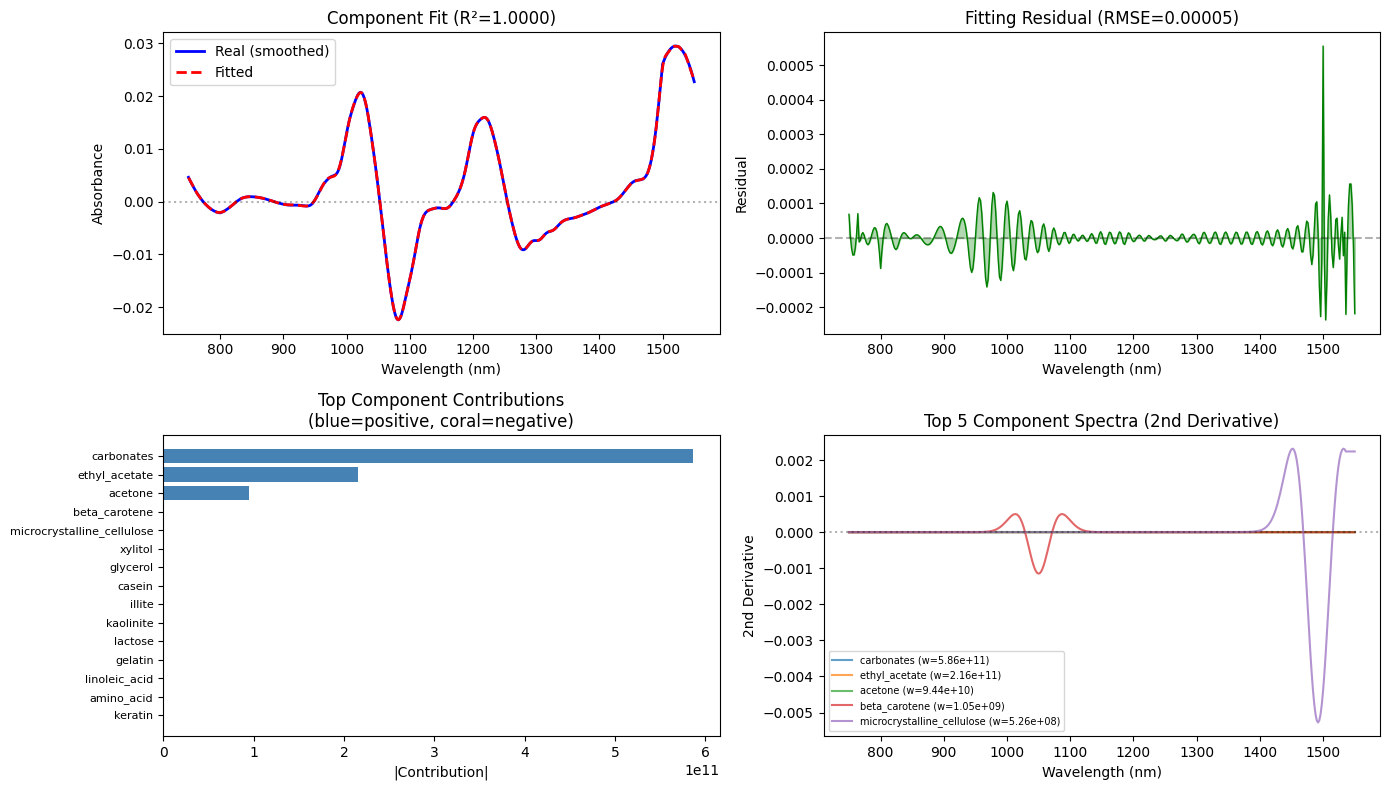


Selected components for generation: ['carbonates', 'ethyl_acetate', 'acetone', 'beta_carotene', 'microcrystalline_cellulose', 'xylitol', 'glycerol', 'casein', 'illite', 'kaolinite']


In [8]:
# Visualize component fit results
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Fitted vs Real median spectrum
axes[0, 0].plot(wavelengths, median_smooth, 'b-', lw=2, label='Real (smoothed)')
axes[0, 0].plot(wavelengths, component_result.fitted_spectrum, 'r--', lw=2, label='Fitted')
axes[0, 0].axhline(0, color='k', ls=':', alpha=0.3)  # Zero line for derivative data
axes[0, 0].set(xlabel='Wavelength (nm)', ylabel='Absorbance',
               title=f'Component Fit (R²={component_result.r_squared:.4f})')
axes[0, 0].legend()

# 2. Residuals
axes[0, 1].plot(wavelengths, component_result.residuals, 'g-', lw=1)
axes[0, 1].axhline(0, color='k', ls='--', alpha=0.3)
axes[0, 1].fill_between(wavelengths, component_result.residuals, 0, alpha=0.3, color='g')
axes[0, 1].set(xlabel='Wavelength (nm)', ylabel='Residual',
               title=f'Fitting Residual (RMSE={component_result.rmse:.5f})')

# 3. Top component contributions (by absolute value for derivatives)
top_components = component_result.top_components(15, threshold=0.001)
if top_components:
    names, weights = zip(*top_components)
    # For derivatives, show absolute contributions with color coding for sign
    abs_weights = [abs(w) for w in weights]
    colors = ['steelblue' if w >= 0 else 'coral' for w in weights]
    y_pos = np.arange(len(names))
    bars = axes[1, 0].barh(y_pos, abs_weights, color=colors)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(names, fontsize=8)
    axes[1, 0].set(xlabel='|Contribution|', title='Top Component Contributions\n(blue=positive, coral=negative)')
    axes[1, 0].invert_yaxis()

# 4. Component spectra for top contributors (show preprocessed if applicable)
top_5_names = [name for name, _ in top_components[:5]]
if top_5_names:
    library = ComponentLibrary.from_predefined(top_5_names, random_state=42)
    top_spectra = library.compute_all(wavelengths)

    # If derivative preprocessing, show derivative of components
    if is_derivative:
        from scipy.signal import savgol_filter
        deriv_order = 2 if fitted_params.preprocessing_type == "second_derivative" else 1
        top_spectra_display = np.array([
            savgol_filter(spec, window_length=15, polyorder=2, deriv=deriv_order)
            for spec in top_spectra
        ])
        ylabel = f'{deriv_order}nd Derivative'
    else:
        top_spectra_display = top_spectra
        ylabel = 'Absorbance'

    for i, (name, weight) in enumerate(top_components[:5]):
        axes[1, 1].plot(wavelengths, top_spectra_display[i], label=f'{name} (w={weight:.2e})', alpha=0.7)
    axes[1, 1].axhline(0, color='k', ls=':', alpha=0.3)
    axes[1, 1].set(xlabel='Wavelength (nm)', ylabel=ylabel, title=f'Top 5 Component Spectra ({ylabel})')
    axes[1, 1].legend(fontsize=7)

plt.tight_layout()
plt.show()

# Store top components for generator (by absolute contribution)
detected_components = [name for name, _ in component_result.top_components(10, threshold=0.01)]
print(f"\nSelected components for generation: {detected_components}")

---
## 5. Generate Synthetic Spectra

Create a generator using the fitted parameters and generate synthetic data.

**Important Note for Preprocessed Data:**
When the real data is already preprocessed (e.g., second derivative), the generation process requires extra care:
1. The generator creates **raw absorbance spectra** based on chemical components
2. We then apply the **same preprocessing** (derivative) to match the real data format
3. Scatter/baseline effects are disabled since they're removed by derivative preprocessing
4. The component fitting (above) matches the **median spectrum** shape, but sample-to-sample variations come from concentration sampling which may differ from real variations

For best results with preprocessed data, consider using raw (non-preprocessed) real data if available.

In [23]:
# Create generator using the fitted parameters
generator = fitter.create_matched_generator(random_state=42)

# Override the component library with detected components if available
if detected_components:
    generator.library = ComponentLibrary.from_predefined(detected_components, random_state=42)
    generator.E = generator.library.compute_all(generator.wavelengths)

# For preprocessed data (derivative), we need to disable effects that are
# removed by preprocessing (scatter, baseline, tilt) and reduce noise
if is_derivative:
    print("Data is preprocessed - disabling scatter/baseline effects for cleaner generation")
    generator.params.update({
        'noise_base': fitted_params.noise_base * 0.1,  # Reduce noise (derivative removes noise via smoothing)
        'noise_signal_dep': fitted_params.noise_signal_dep * 0.1,
        'scatter_alpha_std': 0.0,  # Scatter is removed by derivative/SNV
        'scatter_beta_std': 0.0,
        'path_length_std': 0.0,    # Path length effects are normalized out
        'tilt_std': 0.0,           # Baseline tilt is removed by derivative
        'global_slope_mean': 0.0,  # No baseline slope
        'global_slope_std': 0.0,
    })
else:
    # Apply fitted scatter/noise parameters for raw data
    generator.params.update({
        'noise_base': fitted_params.noise_base,
        'noise_signal_dep': fitted_params.noise_signal_dep,
        'scatter_alpha_std': fitted_params.scatter_alpha_std,
        'scatter_beta_std': fitted_params.scatter_beta_std,
        'path_length_std': fitted_params.path_length_std,
        'tilt_std': fitted_params.tilt_std,
        'global_slope_mean': fitted_params.global_slope_mean,
        'global_slope_std': fitted_params.global_slope_std,
    })

print(f"Generator: {generator}")
print(f"\nKey parameters:")
for key in ['noise_base', 'scatter_alpha_std', 'tilt_std', 'global_slope_mean']:
    print(f"  {key}: {generator.params.get(key, 'N/A')}")

Data is preprocessed - disabling scatter/baseline effects for cleaner generation
Generator: SyntheticNIRSGenerator(wavelengths=750.0-1550.0nm, n_wavelengths=401, n_components=10, complexity='complex')

Key parameters:
  noise_base: 6.828456235079165e-05
  scatter_alpha_std: 0.0
  tilt_std: 0.0
  global_slope_mean: 0.0


In [ ]:
# Generate synthetic spectra
X_synth_raw, C_synth, E_synth, metadata = generator.generate(
    n_samples=len(X_real),
    return_metadata=True
)

# Apply same preprocessing as detected in real data
if is_derivative:
    from scipy.signal import savgol_filter
    deriv_order = 2 if fitted_params.preprocessing_type == "second_derivative" else 1

    # IMPORTANT: Savitzky-Golay with derivative simultaneously smooths AND differentiates
    # Use larger window for smoothing - typical for NIRS is 11-21 points
    window_length = 21
    if window_length > len(wavelengths):
        window_length = len(wavelengths) // 2 * 2 + 1

    X_synth = np.array([
        savgol_filter(spec, window_length=window_length, polyorder=3, deriv=deriv_order)
        for spec in X_synth_raw
    ])

    # Clip edge regions where SG filter has boundary artifacts
    # Use mode='interp' next time, but for now just clip outliers
    p_low, p_high = np.percentile(X_synth, [0.5, 99.5])
    X_synth = np.clip(X_synth, p_low, p_high)

    print(f"Applied {fitted_params.preprocessing_type} preprocessing (SG window={window_length})")
else:
    X_synth = X_synth_raw

# Scale to match real data distribution (zero-mean then scale, then shift)
X_synth_centered = X_synth - X_synth.mean()
scale_factor = X_real.std() / (X_synth_centered.std() + 1e-10)
X_synth = X_synth_centered * scale_factor + X_real.mean()

print(f"Generated {X_synth.shape[0]} samples")
print(f"Synthetic range: [{X_synth.min():.4f}, {X_synth.max():.4f}]")
print(f"Real range:      [{X_real.min():.4f}, {X_real.max():.4f}]")

Applied second_derivative preprocessing (SG window=21)
Generated 263 samples
Synthetic range: [-0.0603, 0.0554]
Real range:      [-0.0409, 0.0628]


---
## 6. Evaluate Similarity

Compare synthetic vs real data using multiple metrics.

In [28]:
# Evaluate similarity using the fitter's built-in method
similarity_metrics = fitter.evaluate_similarity(X_synth, wavelengths)

print("=" * 60)
print("SIMILARITY METRICS")
print("=" * 60)
for key, value in similarity_metrics.items():
    if isinstance(value, float):
        print(f"  {key:<30}: {value:>10.4f}")
    else:
        print(f"  {key:<30}: {value}")

# Also use compare_datasets convenience function
comparison = compare_datasets(X_synth, X_real, wavelengths)
print(f"\n  Overall similarity score: {comparison['overall_score']:.1f}/100")

SIMILARITY METRICS
  mean_rel_diff                 :     0.0000
  std_rel_diff                  :    -0.0000
  slope_diff                    :    -0.0111
  slope_ratio                   :     0.1816
  noise_ratio                   :     1.0418
  snr_ratio                     :     8.5043
  pca_complexity_diff           : 5
  mean_spectrum_correlation     :     0.0999
  slope_ks_statistic            :     0.9962
  slope_ks_pvalue               :     0.0000
  overall_score                 :    76.4520

  Overall similarity score: 76.5/100


In [29]:
# Compute spectral properties for synthetic data
synth_props = compute_spectral_properties(X_synth, wavelengths, name="synthetic")

print(f"{'Property':<25} {'Real':>12} {'Synthetic':>12} {'Diff%':>10}")
print("=" * 62)
comparisons = [
    ('Global mean', real_props.global_mean, synth_props.global_mean),
    ('Global std', real_props.global_std, synth_props.global_std),
    ('Mean slope', real_props.mean_slope, synth_props.mean_slope),
    ('Slope std', real_props.slope_std, synth_props.slope_std),
    ('Noise estimate', real_props.noise_estimate, synth_props.noise_estimate),
    ('SNR estimate', real_props.snr_estimate, synth_props.snr_estimate),
    ('PCs for 95%', real_props.pca_n_components_95, synth_props.pca_n_components_95),
]
for name, r, s in comparisons:
    diff = (s - r) / (abs(r) + 1e-10) * 100
    print(f"{name:<25} {r:>12.4f} {s:>12.4f} {diff:>+10.1f}%")

Property                          Real    Synthetic      Diff%
Global mean                     0.0026       0.0026       +0.0%
Global std                      0.0131       0.0131       -0.0%
Mean slope                      0.0136       0.0025      -81.8%
Slope std                       0.0005       0.0019     +297.6%
Noise estimate                  0.0014       0.0014       +4.2%
SNR estimate                    0.4334       3.6860     +750.4%
PCs for 95%                     3.0000       8.0000     +166.7%


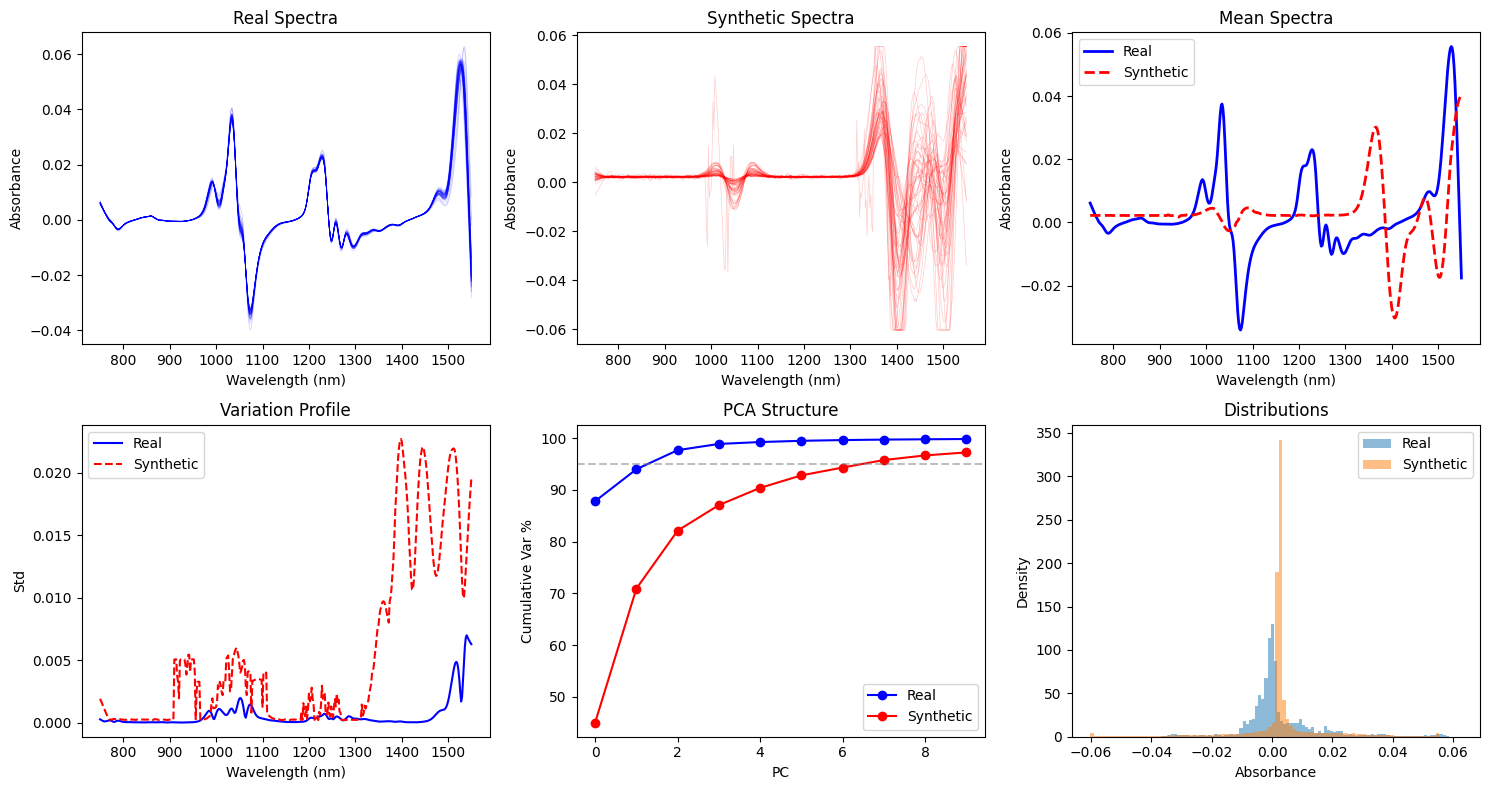

In [27]:
# Visual comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Row 1: Spectra comparison
n_plot = min(50, len(X_real))
for i in np.random.choice(len(X_real), n_plot, replace=False):
    axes[0, 0].plot(wavelengths, X_real[i], 'b-', alpha=0.2, lw=0.5)
axes[0, 0].set(xlabel='Wavelength (nm)', ylabel='Absorbance', title='Real Spectra')

for i in np.random.choice(len(X_synth), n_plot, replace=False):
    axes[0, 1].plot(wavelengths, X_synth[i], 'r-', alpha=0.2, lw=0.5)
axes[0, 1].set(xlabel='Wavelength (nm)', ylabel='Absorbance', title='Synthetic Spectra')

# Mean overlay
axes[0, 2].plot(wavelengths, X_real.mean(0), 'b-', lw=2, label='Real')
axes[0, 2].plot(wavelengths, X_synth.mean(0), 'r--', lw=2, label='Synthetic')
axes[0, 2].set(xlabel='Wavelength (nm)', ylabel='Absorbance', title='Mean Spectra')
axes[0, 2].legend()

# Row 2: Statistical comparison
axes[1, 0].plot(wavelengths, X_real.std(0), 'b-', lw=1.5, label='Real')
axes[1, 0].plot(wavelengths, X_synth.std(0), 'r--', lw=1.5, label='Synthetic')
axes[1, 0].set(xlabel='Wavelength (nm)', ylabel='Std', title='Variation Profile')
axes[1, 0].legend()

# PCA comparison
pca_r = PCA(n_components=10).fit(X_real)
pca_s = PCA(n_components=10).fit(X_synth)
axes[1, 1].plot(np.cumsum(pca_r.explained_variance_ratio_)*100, 'bo-', label='Real')
axes[1, 1].plot(np.cumsum(pca_s.explained_variance_ratio_)*100, 'ro-', label='Synthetic')
axes[1, 1].axhline(95, color='gray', ls='--', alpha=0.5)
axes[1, 1].set(xlabel='PC', ylabel='Cumulative Var %', title='PCA Structure')
axes[1, 1].legend()

# Distribution comparison
axes[1, 2].hist(X_real.flatten(), bins=100, density=True, alpha=0.5, label='Real')
axes[1, 2].hist(X_synth.flatten(), bins=100, density=True, alpha=0.5, label='Synthetic')
axes[1, 2].set(xlabel='Absorbance', ylabel='Density', title='Distributions')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

---
## 7. Discriminator Test

Train a classifier to distinguish real from synthetic. Lower accuracy = better synthetic data.

In [30]:
# Discriminator test
def test_discriminator(X_real, X_synth, n_estimators=100, random_state=42):
    """Train classifier to distinguish real from synthetic. Lower accuracy = better."""
    n = min(len(X_real), len(X_synth))
    rng = np.random.default_rng(random_state)
    idx_r = rng.choice(len(X_real), n, replace=False)
    idx_s = rng.choice(len(X_synth), n, replace=False)

    X = np.vstack([X_real[idx_r], X_synth[idx_s]])
    y = np.array([0]*n + [1]*n)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=10, random_state=random_state, n_jobs=-1)
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    return accuracy_score(y_test, y_pred)

disc_acc = test_discriminator(X_real, X_synth)

print("=" * 60)
print("DISCRIMINATOR TEST")
print("=" * 60)
print(f"Discriminator accuracy: {disc_acc:.3f}")
print(f"Target: <0.60 (hard to distinguish)")
print(f"Ideal:  0.50 (random guessing)")
print()
if disc_acc < 0.55:
    print("✓ EXCELLENT: Synthetic spectra are nearly indistinguishable!")
elif disc_acc < 0.60:
    print("✓ GOOD: Synthetic spectra are hard to distinguish.")
elif disc_acc < 0.75:
    print("⚠ MODERATE: Some distinguishable features remain.")
else:
    print("✗ POOR: Synthetic spectra are easily distinguishable.")

DISCRIMINATOR TEST
Discriminator accuracy: 1.000
Target: <0.60 (hard to distinguish)
Ideal:  0.50 (random guessing)

✗ POOR: Synthetic spectra are easily distinguishable.


---
## 8. Export Configuration

Export the fitted configuration for reuse.

In [31]:
# Export fitted parameters
print("# Fitted configuration for reuse")
print("# ================================")
print()
print("fitted_config = ", end="")
import pprint
pprint.pprint(fitted_params.to_full_config())

print()
print("# Detected components from spectral unmixing")
print(f"detected_components = {detected_components}")

print()
print("# Quick usage:")
print("# from nirs4all.data.synthetic import SyntheticNIRSGenerator, ComponentLibrary")
print("# library = ComponentLibrary.from_predefined(detected_components)")
print("# generator = SyntheticNIRSGenerator(")
print(f"#     wavelength_start={fitted_params.wavelength_start:.1f},")
print(f"#     wavelength_end={fitted_params.wavelength_end:.1f},")
print(f"#     wavelength_step={fitted_params.wavelength_step:.1f},")
print(f"#     component_library=library,")
print(f"#     complexity='{fitted_params.complexity}',")
print("# )")

# Fitted configuration for reuse
# ================================

fitted_config = {'baseline_amplitude': 0.0026125801727175713,
 'complexity': 'complex',
 'components': [],
 'domain': 'unknown',
 'emsc_config': {'additive_scatter_std': 6.676728662569076e-05,
                 'include_wavelength_terms': True,
                 'multiplicative_scatter_std': 0.00047437152595831966,
                 'polynomial_order': 2},
 'global_slope_mean': 0.013572101495481284,
 'global_slope_std': 0.00047437152595831966,
 'instrument': 'scio',
 'is_preprocessed': True,
 'measurement_mode': 'reflectance',
 'moisture_config': {},
 'n_components': 5,
 'noise_base': 0.0006828456235079165,
 'noise_signal_dep': 0.05227365886327075,
 'particle_size_config': {'mean_size_um': 20.0,
                          'size_effect_strength': 1.0,
                          'std_size_um': 6.0},
 'path_length_std': np.float32(0.00033383642),
 'preprocessing_type': 'second_derivative',
 'scatter_alpha_std': 0.039188702590

In [16]:
# Save parameters to file for later reuse
output_path = Path("workspace/fitted_params")
output_path.mkdir(parents=True, exist_ok=True)
params_file = output_path / f"{dataset.name}_fitted_params.json"

fitted_params.save(str(params_file))
print(f"Parameters saved to: {params_file}")

# Demonstrate loading
loaded_params = FittedParameters.load(str(params_file))
print(f"\nLoaded parameters:")
print(f"  Source: {loaded_params.source_name}")
print(f"  Wavelengths: {loaded_params.wavelength_start:.0f}-{loaded_params.wavelength_end:.0f} nm")
print(f"  Complexity: {loaded_params.complexity}")
print(f"  Inferred domain: {loaded_params.inferred_domain}")

TypeError: Object of type float32 is not JSON serializable